<a href="https://colab.research.google.com/github/dschlesinger/experiments/blob/main/pytorch_tutorial/PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Expiriments with PyTorch

### Sections

- Setup
- Compute
- Tensors
- Neural Networks


## Setup

In [1]:
%pip install torch torchvision torchaudio torchmetrics tqdm # torch_xla
%pip install datasets transformers # Hugging face

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import torch, datasets, transformers, numpy as np, matplotlib.pyplot as plt, PIL.Image as Image, requests, torchvision.transforms as transforms #, torch_xla, torch_xla.core.xla_model as xm

from typing import *

device = 'cpu'

if torch.cuda.is_available(): device = 'cuda'

In [3]:
torch.__version__

'2.6.0+cu124'

In [4]:
from enum import Enum

class Color(Enum):
  RED = '\033[31m'
  GREEN = '\033[32m'
  BLUE = '\033[34m'
  BLACK = '\033[30m'
  WHITE = '\033[37m'
  YELLOW = '\033[33m'
  RESET = '\033[0m'

  def apply(self, text: str) -> str:

    return self.value + text + Color.RESET.value

  def __call__(self, text: str) -> None:

    print(self.value + text + Color.RESET.value)

In [5]:
def load_tpu() -> torch.device | None:
  try:
    tpu_device = xm.xla_device()
    Color.GREEN("Found tpu")
    return tpu_device
  except RuntimeError as RE:
    Color.RED("Could not find tpu")
  return

# device = load_tpu() or device

In [6]:
from itertools import repeat

def fibbonaci(i: int) -> int:
  """Computes fibbonnaci with dynamic programming

  Args:
    i: int

  Returns:
    int: 0 if i <= 0 else fib(i)
  """

  if i <= 0: return 0

  # Start at step 1
  window = [0, 1]

  for _ in repeat(None, i - 1):

    window = [window[1], window[0] + window[1]]

  return window[1]

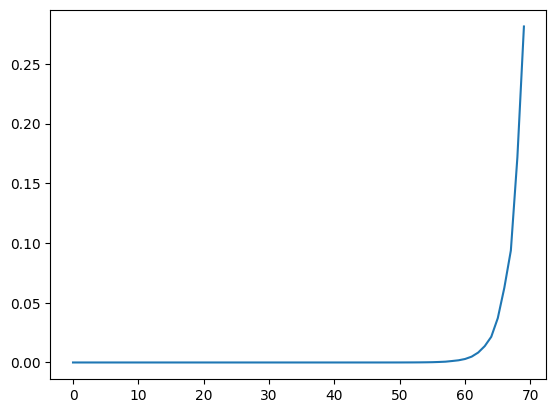

In [7]:
# testing golden ratio

t = 70

error = []

phi = (1 + (5 ** 0.5)) / 2

func = lambda x: (((phi) ** x) - (1 - phi) ** x) / (5 ** 0.5)

for i in range(t):

  error.append(
      func(i) - fibbonaci(i)
  )

plt.plot(range(t), error)

## Compute
- CPU
- Workers
- GPU
- TPU
- Moving
- Benchmarking

### CPU

In [ ]:
# Find devices

import psutil

# Get CPU Stats

ncpus: int = psutil.cpu_count(logical=False)
nthreads: int = psutil.cpu_count(logical=True) # Same as torch.get_num_cpus()

print(
    f"Num CPUS: {ncpus}",
    f"Num Threads: {nthreads}",
    "",
    sep='\n'
)

# Control Torch CPU Acsess, test speed

n: int = 5000

print("Torch with 1 thread")

torch.set_num_threads(1)

%time _ = torch.mm(torch.randn(n, n, device='cpu'), torch.randn(n, n, device='cpu'))

print()

print(f"Torch with {nthreads} thread")

torch.set_num_threads(nthreads)

%time _ = torch.mm(torch.randn(n, n, device='cpu'), torch.randn(n, n, device='cpu'))

# Slightly slower as hyper threading and overhead

Num CPUS: 48
Num Threads: 96

Torch with 1 thread
CPU times: user 1.89 s, sys: 143 ms, total: 2.03 s
Wall time: 2.02 s

Torch with 96 thread
CPU times: user 8.23 s, sys: 506 ms, total: 8.74 s
Wall time: 2.34 s


### Workers

In [ ]:
# For loading data in parallel

from torch.utils.data import DataLoader, Dataset

n: int = 1_000_000

class MyDataset(Dataset):

    def __init__(self, n) -> None:

      self.n = n

    def __getitem__(self, index):
        return index  # Simulated data point
    def __len__(self):
        return self.n

def worker_load_test(nworkers: int) -> None:
  dataset = MyDataset(n)
  dataloader = DataLoader(dataset, batch_size=32, num_workers=nworkers)

  for batch in dataloader:
      _ = batch

# Test times

for t in range(1, nthreads + 1):

  print(f"Using {t} threads")

  %time worker_load_test(t)

  print()

Using 1 threads
CPU times: user 15.2 s, sys: 5.38 s, total: 20.6 s
Wall time: 35.4 s

Using 2 threads
CPU times: user 15.2 s, sys: 5.32 s, total: 20.5 s
Wall time: 33.9 s



### GPU

In [ ]:
# Use GPU runtime

found_gpu: bool = torch.cuda.is_available()

ngpus: int = 0 if not found_gpu else torch.cuda.device_count()

gpu_names: List[str] = [torch.cuda.get_device_name(i) for i in range(ngpus)]

print(f"Found GPU: {found_gpu}",
      f"Num GPU: {ngpus}",
      "",
      "GPUs Found:",
      *[f'{name}' for name in gpu_names],
      sep='\n'
)

Found GPU: True
Num GPU: 1

GPUs Found:
Tesla T4


In [ ]:
import subprocess
import time
from IPython.display import clear_output

# Runs nvidia-smi cmd continuously
while True:
    clear_output(wait=True)
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print(result.stdout)
    time.sleep(1)

Thu Mar 27 17:47:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

KeyboardInterrupt: 

In [ ]:
# Check memory usage before allocation
print("Pre allocation")
print(f"{torch.cuda.memory_allocated() / (8 * (1024)**2):.2f}MB")
print()

# Allocate a large tensor
a = torch.ones(size=(10000, 10000), device=device)

# Check memory usage after allocation
print("Post allocation")
print(f"{torch.cuda.memory_allocated() / (8 * (1024)**2):.2f}MB")
print()

# Clear the tensor and free memory
del a

import gc
_ = gc.collect()

# Check memory usage after deleting
print("After deletion")
print(f"{torch.cuda.memory_allocated() / (8 * (1024)**2):.2f}MB")
print()

Pre allocation
0.00MB

Post allocation
47.75MB

After deletion
0.00MB



### TPU

In [ ]:
a = torch.randint(low=-5, high=5, size=(1000, 1000), dtype=torch.float, device=tpu_device)
b = torch.randint(low=-5, high=5, size=(1000, 1000), dtype=torch.float, device=tpu_device)

# Tpus do lazy exectution this does not compute
r = torch.matmul(a, b)

print(
    "Result Shape: ",
    r.shape,
    "\n",
    "Result Device: ",
    r.device,
    sep='',
)

Result Shape: torch.Size([1000, 1000])
Result Device: xla:0


In [ ]:
r # <-- Now it does as it prints

tensor([[ 505.,  134.,  436.,  ...,  228., -107., -192.],
        [ 662.,   61.,  123.,  ...,   -2.,  134.,  683.],
        [ 195.,   87.,  372.,  ...,  569.,  379.,  110.],
        ...,
        [ 114.,  506.,  348.,  ...,  -36.,  443.,  295.],
        [ 203.,  546.,  -69.,  ...,  145., -158.,  748.],
        [ 419.,  -64.,  131.,  ...,  190., -181.,  -59.]], device='xla:0')

### Moving

In [ ]:
# Make var on cpu
A: torch.Tensor = torch.tensor([1,2,3], dtype=torch.int)

print(
    "A is on the",
    A.device
)

# Make var on gpu

B: torch.Tensor = torch.tensor([1,2,3], dtype=torch.int, device=device)

print(
    "B is on the",
    B.device
)

# Doing opperations across devices
try:
  A + B
except RuntimeError as RE:
  Color.RED("Cannot do opperations across devices")
print()

# Must transfer with .to()

# to gpu
print(
    t := A.to(device) + B,
    "\n",
    "On: ",
    t.device,
)

print()

# to cpu
print(
    t := A + B.to('cpu'),
    "\n",
    "On: ",
    t.device,
)

A is on the cpu
B is on the cuda:0
Cannot do opperations across devices

tensor([2, 4, 6], device='cuda:0', dtype=torch.int32) 
 On:  cuda:0

tensor([2, 4, 6], dtype=torch.int32) 
 On:  cpu


### Benchmarking

In [ ]:
# Benchmark matmul as dim scales (log)

import timeit, random
from IPython.display import clear_output

n: int = 5

tests = np.linspace(0, n, 100)
cpu_times = np.zeros_like(tests)
device_times = np.zeros_like(tests) # GPU or TPU

for i, d in enumerate(tests):

  clear_output(wait=True)
  print(f"{d}/{n}")

  a = torch.randint(low=-5, high=5, size=(int(10**d), int(10**d)), dtype=torch.float, device='cpu')
  b = torch.randint(low=-5, high=5, size=(int(10**d), int(10**d)), dtype=torch.float, device='cpu')

  # Excecute on cpu
  cpu_times[i] = timeit.timeit(lambda: torch.matmul(a, b), number=1)

  a = a.to(device)
  b = b.to(device)

  with open('log.txt', 'w') as logtxt:

    device_times[i] = timeit.timeit(lambda: print(torch.matmul(a, b), file=logtxt), number=1)


4.444444444444445/5


KeyboardInterrupt: 

x - dim of mat log <br>
y - seconds for matmul

CPU vs GPU

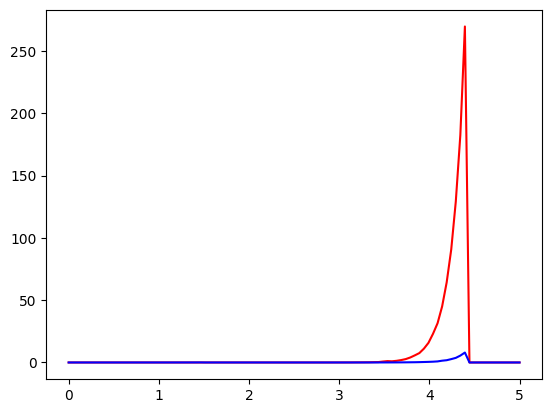

CPU vs TPU

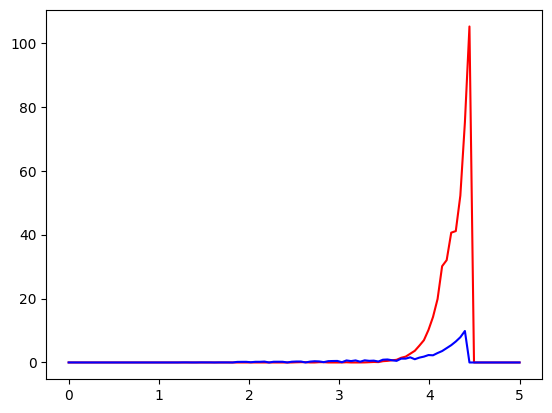

## Tensors
 - Basics
 - Math
 - Autograd

### Basics

In [ ]:
# Creating and Typing
a: torch.Tensor = torch.tensor([1,2,3], dtype=torch.long)

for x in filter(lambda x: callable(x), (getattr(torch, name) for name in dir(torch))):
    continue

    name = x.__name__
    doc = x.__doc__
    doc_summary = doc.__str__()[:50].replace("\n", "") if doc else None
    print(f"{name:<20}{doc_summary}")

# Function for creating tensors

z = torch.zeros((2,2))

o = torch.ones((2,2))

f = torch.full((2,2), fill_value=3)

i = torch.eye(2)

# tensor with shape of other tensor

z = torch.zeros_like(z)

o = torch.ones_like(o)

f = torch.full_like(f, fill_value=3)

# Random

r = torch.rand((2,2)) # [0, 1]

rn = torch.randn((2,2)) # normal mean 0 std 1

ri = torch.randint(size=(2,2), low=0, high=2) # uniform int [low, high)

rp = torch.randperm(10) # for shuffling

# Ranges

ar = torch.arange(0, 10.5, 0.5)

ls = torch.linspace(0, 10, 21)

# Set seed for reproducability

torch.manual_seed(42)

print(torch.randint(0, 100, (1,)).item())
print(torch.randint(0, 100, (1,)).item())

# Create generator

g = torch.Generator()

g.manual_seed(24)

print(torch.randint(0, 100, (1,), generator=g).item())
print(torch.randint(0, 100, (1,), generator=g).item())

42
67
14
55


In [ ]:
# Shaping and Slicing

# Slicing
at = torch.randint(size=(2,2,2), low=0, high=3)
an = np.random.randint(size=(2,2,2), low=0, high=3)

# Almost same as numpy : = all, -indexing
at[:,:,:]
an[:,:,:]

# Diffrence is bool masking

# Numpy
mask = an > 1
an[mask]

# Torch
mask = at > 1
torch.masked_select(at, mask)

# ? also support boolean indexing
at[mask]

# Shape
b = torch.randint(size=(2,2,2), low=0, high=3)

print(b.shape)
print(b.stride())

# Gets shape
s = b.shape

# Gets number of elements
s.numel()

# Gets stride, skips x to get next position in dim
st = b.stride()

# Reshape, ensure continguous
b = b.reshape((-1,2,1))

print(b.shape)
print(b.stride())

# Transpose
b = b.transpose(0,1) # | .t() for 2D

print(b.shape)
print(b.stride())

# Permute
b = b.permute((1,0,2))

print(b.shape)
print(b.stride())

# Add new dim, size 1
b = b.unsqueeze(-1)

# Remove new dim, size 1
b = b.squeeze(-1)

print(b.shape)
print(b.stride())

# Flatten

b = b.flatten()

print(b.shape)
print(b.stride())

pass

torch.Size([2, 2, 2])
(4, 2, 1)
torch.Size([4, 2, 1])
(2, 1, 1)
torch.Size([2, 4, 1])
(1, 2, 1)
torch.Size([4, 2, 1])
(2, 1, 1)
torch.Size([4, 2, 1])
(2, 1, 1)
torch.Size([8])
(1,)


In [ ]:
# Shaping part 2

# Contiguous, each dim is in order in memory [[0,1], [2,3]] -> 0 1 2 3

a = torch.randint(size=(2,2,2), low=0, high=3)

print("A is contiguous", a.is_contiguous())

# if we use contiguous here just points as a is contiguous

t = a.contiguous()

print("T points to A", id(a) == id(t))

# Makes uncontigous
b = a.permute((2,1,0))

print("B is contiguous", b.is_contiguous())

print("B points to A", id(a) == id(b))

# Copies if not contigous
c = b.contiguous()

print("C is contiguous", c.is_contiguous())

print("C points to A", id(a) == id(c))

A is contiguous True
T points to A True
B is contiguous False
B points to A False
C is contiguous True
C points to A False


In [ ]:
# Shape part 3, shapes with multiple tensors

a = torch.randint(size=(3,3), low=0, high=5)
b = torch.randint(size=(3,3), low=0, high=5)

# Concatonate (along current dim) (k, n) (q, n) dim=0 -> (k+q, n)
print(
    f".cat() ({a.shape}), ({b.shape}) -> {torch.cat([a, b], dim=0).shape}\n"
)

# Stack (create new dim) (m, (k, n)) dim=-1 -> (k, n, m)
print(
    f".stack() ({a.shape}), ({b.shape}) -> {torch.stack([a, b], dim=-1).shape}\n"
)

# VStack (stack if dim < 2 else cat)
print(
    f".vstack() ({a.shape}), ({b.shape}) -> {torch.vstack([a, b]).shape}\n"
)

# HStack (cat if dim < 2 else stack dim=1)
print(
    f".hstack() ({a.shape}), ({b.shape}) -> {torch.hstack([a, b]).shape}\n"
)

# Split (n, m, k) 3: int -> (*(ceil(n/3) - 1, (3, m, k)), (1, (n % 3, m, k)) returns tuple
print(
    [x.shape for x in torch.split(a, 2)]
)

.cat() (torch.Size([3, 3])), (torch.Size([3, 3])) -> torch.Size([6, 3])

.stack() (torch.Size([3, 3])), (torch.Size([3, 3])) -> torch.Size([3, 3, 2])

.vstack() (torch.Size([3, 3])), (torch.Size([3, 3])) -> torch.Size([6, 3])

.hstack() (torch.Size([3, 3])), (torch.Size([3, 3])) -> torch.Size([3, 6])

[torch.Size([2, 3]), torch.Size([1, 3])]


torch.Size([800, 1200, 3])
(3600, 3, 1)
(1125, 3, 1)


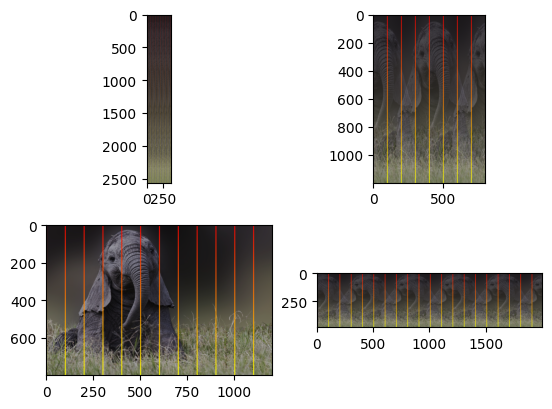

In [ ]:
# Example with Image

url = "https://lp-cms-production.imgix.net/2024-04/GettyImages-143795695.jpg?auto=format,compress&q=72&fit=crop&w=1200"

image = Image.open(requests.get(url, stream=True).raw)

x = transforms.ToTensor()(image).permute((1,2,0)).contiguous() # Permute as image is 3, x, y (channel , x, y) -> x, y, 3

print(x.shape)

fig, axs = plt.subplots(2,2)

axs = axs.flatten()

# Add tracers, 5x5 patch every 100

rows = torch.arange(x.shape[0]) % 100 < 100
cols = torch.arange(x.shape[1]) % 100 < 5
mask = rows.unsqueeze(-1) & cols.unsqueeze(-1).T

# Dim image
x = x * 0.7

# Dots to gradient

l = torch.linspace(0, 1, mask.sum())

gradient = torch.zeros((mask.sum(), 3))

gradient[:, 0] = 1
gradient[:, 1] = l
gradient[:, 2] = 0

x[mask] = gradient

print(x.stride())
print(x.view(-1, 375, 3).stride())

# axs[0].imshow(x)
# axs[1].imshow(x.transpose(0,1))
# axs[2].imshow(x.max()- x)
axs[0].imshow(x.view((-1, 375, 3)))
axs[1].imshow(x.view((-1, 800, 3)))
axs[2].imshow(x.view((-1, 1200, 3)))
axs[3].imshow(x.view((-1, 2000, 3)))

Min -3.483419895172119 at 745 | -3.483419895172119
Max 3.4682559967041016 at 135 | 3.4682559967041016
Arg sort top 5 tensor([745,  99, 275, 366, 606])
Sort value top 5 tensor([3.4683, 3.3567, 2.8898, 2.6644, 2.5964])
tensor([[ 3, 15,  0],
        [ 4, 23,  0],
        [ 5,  7,  0],
        [ 8, 27,  0],
        [ 9, 23,  0],
        [13,  2,  0],
        [13, 19,  0],
        [21, 18,  0],
        [25, 13,  0],
        [26, 17,  0]])
Any pixels > 3 stds?: True


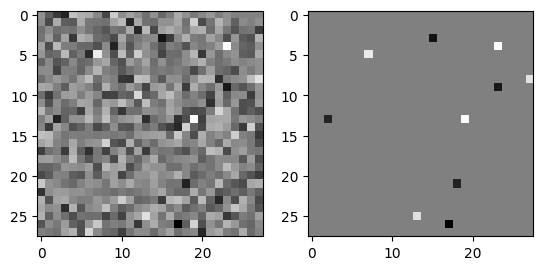

In [ ]:
img = torch.randn((28,28,1), dtype=torch.float)

# Max and min
print(
    f"Min {img.min()} at {img.argmin()} | {img.flatten()[img.argmin()]}",
    f"Max {img.max()} at {img.argmax()} | {img.flatten()[img.argmax()]}",
    f"Arg sort top 5 {img.flatten().argsort()[:5]}",
    f"Sort value top 5 {img.flatten().topk(5).values}",
    sep='\n',
)

# Get indicies of mask
mask = img.abs() > 2.5 # 2.5 stds

print(
    mask.argwhere()
)

print(
    "Any pixels > 3 stds?:", (img.abs() > 3).any().item()
)

fig, axs = plt.subplots(1, 2)

axs = axs.flatten()

axs[0].imshow(img, cmap='gray')

img[~mask] = 0

axs[1].imshow(img, cmap='gray')

In [ ]:
# Ensures everything is reproducable, ChatGPT
import random
import numpy as np
import torch

seed = 42

random.seed(seed)  # Python’s built-in random module
np.random.seed(seed)  # NumPy random seed
torch.manual_seed(seed)  # PyTorch CPU seed
torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
torch.cuda.manual_seed_all(seed)  # All GPUs
torch.backends.cudnn.deterministic = True  # Ensures deterministic CNN results
torch.backends.cudnn.benchmark = False  # Disables optimization for reproducibility

#### Types

##### **Floats**
float16 => torch.float16 | torch.half <br>
float32 => torch.float32 | torch.float <br>
float64 => torch.float64 | torch.double <br>

##### **Ints**
uint8 => torch.uint8 @depricated <br>
int8 => torch.int8 <br>
int16 => torch.int16 | torch.short <br>
int32 => torch.int32 | torch.int <br>
int64 => torch.int64 | torch.long <br>

##### **Bool**
bool => torch.bool <br>

##### **Complex Numbers, two floats**
complex64 => torch.complex64 | torch.float32 + torch.float32 <br>
complex128 => torch.complex128 | torch.float64 + torch.float64 <br>

##### **Quantization**
qint8 => torch.qint8 <br>
quint8 => torch.quint8 <br>
qint32 => torch.qint32 <br>

##### **Brain Floats**
bfloat16 => torch.bfloat16 (same range as float32 less precise) <br>

### Math

#### Basic Operations

In [ ]:
# Basics

a = torch.randint(size=(2,2), low=0, high=10, dtype=torch.float)

b = torch.ones((2,2))

# Add

a + b

# Sub

a - b

# elem multi

a * b

# elem div

a / b

# Mat mul

a @ b

# Batch matmul, faster, shapes must be (batch, N, M) (batch, K, N)

torch.bmm(
    torch.randn(10, 4, 5),
    torch.randn(10, 5, 4),
)

# mm then add, for linear layer, faster on gpu

torch.addmm(
    torch.randn(10, 10), # Bias
    torch.randn(10, 5), # Weights
    torch.randn(5, 10), # Inputs
)

# Absolute
a.abs()

# Square
a ** 2

# Sqrt
a.sqrt()

# Exponential (e^a)
a.exp()

# Natural logarithm, ln
a.log()

# Log 10
a.log10()

# Stats

# Sum
a.sum()

# Mean / median / mode
a.mean()
a.median()
a.mode()

# std / var / quantiles
a.std()
a.var()
a.quantile(0.75)

# Extremes
a.min()
a.max()

# Values to [min, max]
a.clamp(0,1)

# Position of max / min
a.argmax()
a.argmin()

# Get number of non-zero elements
a.count_nonzero()

# Sort, returns (values=[...], indices=[...])

# Get top k items, returns (values=[...], indices=[...])
a.flatten().topk(3)

# Binning, equal size between min and max, else data min and max
a.histc(4)

# PDF, dim key word, return in size of dim use compress on other dims
b.flatten().cumsum(dim=-1)

# Get unique
b.unique(return_counts=True)

pass

In [ ]:
# Benchmarking mm vs bmm, would only matter on very large batches, mm detected batches now

b: int = int(1e4)

a, b = torch.randn(b, 100, 100), torch.randn(b, 100, 100)

%timeit torch.matmul(a, b)
%timeit torch.bmm(a, b)

pass

661 ms ± 6.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
730 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Linalg

In [ ]:
a = torch.randint(size=(3,3), low=0, high=6, dtype=torch.float)

b = torch.randint(size=(3,), low=0, high=6, dtype=torch.float)

# diagonal

a.diag()

# trace, sum diag

a.trace()

# Get rank

torch.linalg.matrix_rank(a)

# Get determinant

assert a.det() != 0, "Matrix is singular"

# Numerically stable log determinant, for large matrix
sign, abslogdet = torch.linalg.slogdet(a)
# a = sign * exp(abslogdet)

# Norm

# L1
torch.linalg.norm(b, ord=1)

# L2
torch.linalg.norm(b, ord=2)

# L any p, sum(i ** p) ** 1/p
p: int = 9
torch.linalg.norm(b, ord=p)

# inverse

a.inverse()

# rref, through lu

P, L, U = torch.lu_unpack(
    *torch.linalg.lu_factor(a)
)


# QR decomp
Q, R = torch.linalg.qr(a)

# Eigen, returns complex
eigenvalues, eigenvectors = torch.linalg.eig(a)
eigvals_real = torch.linalg.eigvalsh(a)

# Matrix SVD
U, S, V = torch.linalg.svd(a)

# Solving linear system, a must be square
torch.linalg.solve(a, b)

# Solve least square solution, rows > columns -> projection, columns > rows min norm
torch.linalg.lstsq(a, b)
# In this case same as solve

# element wise aii * a (k, m) (q, n) -> (kq, mn)
torch.kron(a, a)

pass

### Autograd

In [ ]:
# compute the gradient of a variable with respect to another variable
# Tracks operations using a graph

a = torch.tensor(2.0, requires_grad=True)

loss = (a - 4) ** 2

loss.backward()

print(a.grad)

# remove history
a.grad.zero_()

print(a.grad)

tensor(-4.)
tensor(0.)


In [ ]:
# Not using grad

with torch.no_grad():
  pass

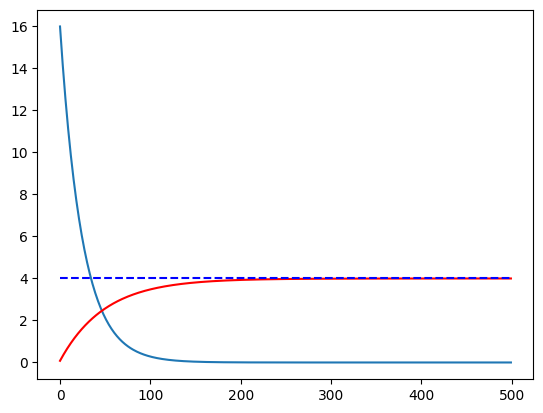

In [ ]:
# Simple training loop

from itertools import repeat

a = torch.tensor(torch.randint(size=(1,), low=-100, high=100, dtype=torch.float).item(), requires_grad=True)

# Optimal solution is 4
loss_fn = lambda x: (x - 4) ** 2

epochs: int = 500
lr: float = 1e-2

# Track
loss_hist = []
a_hist = []

for _ in repeat(None, epochs):

  loss = loss_fn(a)

  loss_hist.append(loss.item())

  loss.backward()

  # print(
  #     f"A ({a.item()} -> {a.item() - lr * a.grad.item()})",
  #     f"Loss: {loss.item()}",
  #     f"Grad: {a.grad.item()}",
  #     "",
  #     sep='\n'
  # )

  a = torch.tensor(float(a.item() - lr * a.grad.item()), requires_grad=True)

  a_hist.append(a.item())

  if a.grad: a.grad.zero_()

plt.plot(range(epochs), loss_hist)
plt.plot(range(epochs), a_hist, 'r')
plt.plot(range(epochs), list(repeat(4, epochs)), 'b--')

## Neural Networks

- Dataloaders
- Linear Model (Fibonnaci)
- Linear Model (MNIST)
- RNN Model (IMDB)

In [8]:
import copy

from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms, datasets as vdatasets

from torchvision.datasets import MNIST, CIFAR10
from datasets import load_dataset

### Dataloaders

In [ ]:
# Fit model on fibonnaci, test for generalization, it wont lol

x = torch.arange(0, 30, 1)

y = torch.tensor(list(map(fibbonaci, x)))

p = torch.randperm(x.shape[0])

x, y = x[p], y[p]

cutoff: int = 25

x_train, y_train, x_test, y_test = x[:cutoff], y[:cutoff], x[cutoff:], y[cutoff:]

# Validate on 30 - 40

x_val = torch.arange(30, 40, 1)

y_val = torch.tensor(list(map(fibbonaci, x_val)))

In [ ]:
# Create a dataset

from dataclasses import dataclass

@dataclass
class FibbonaciSet(Dataset):

  def __init__(self, x, y):

    self.x = x.to(torch.double)

    # Log for numerical stability
    self.y = y.to(torch.double).log()

  def __len__(self) -> int:

    return self.x.shape[0]

  def __getitem__(self, idx: int) -> Tuple[torch.long, torch.long]:

    return self.x[idx], self.y[idx]

train = FibbonaciSet(x_train, y_train)
test = FibbonaciSet(x_test, y_test)
val = FibbonaciSet(x_val, y_val)

# indexing (x, y)
train[0:3]

# iterating
for x, y in train:
  break

# Concat datasets
unseen = ConcatDataset([test, val])

pass

In [ ]:
# Dataloaders

train_loader = DataLoader(
    train,
    batch_size=4,
    shuffle=True,
    num_workers=2, # <-- For computation
    pin_memory=False, # <-- For GPU things
    drop_last=False, # <-- For incomplete batches
)

test_loader = DataLoader(
    test,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=False,
    drop_last=False,
)

val_loader = DataLoader(
    val,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=False,
    drop_last=False,
)

# iterating
for x, y in train_loader:
  break

# Does not support indexing
try:
  train_loader[0]
except TypeError as TE:
  print("Does not")

Does not


### Linear Model (Fibonnaci)

In [ ]:
# Build

import torch.nn as nn
from torch.nn import functional as f

class Model(nn.Module):

  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(1, 10)
    self.fc2 = nn.Linear(10, 10)
    self.fc3 = nn.Linear(10, 1)

  def forward(self, x):

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)

    return x

model = Model()
naive_model = copy.deepcopy(model)
model = model.to(torch.double)

In [ ]:
# Compile (optional)

# model = torch.compile(model)

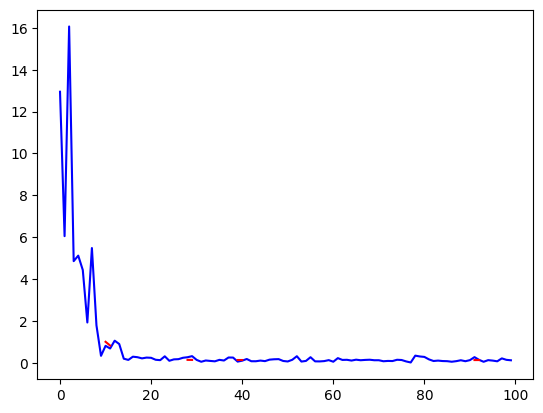

In [ ]:
# Train

from IPython.display import clear_output

train_hist = []
test_hist = []

loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=1e-5)

epochs: int = 100

for i in range(epochs):

  print(
      f"Epoch: {i + 1}/{epochs}"
  )

  clear_output(wait=True)

  for x, y in train_loader:

    optimizer.zero_grad()

    output = model(x.unsqueeze(-1)).squeeze(-1)

    loss = loss_fn(y, output)

    train_hist.append(loss.item())

    loss.backward()
    optimizer.step()

  for x, y in test_loader:

    test_hist.append(
        loss_fn(
            y, model(x.unsqueeze(-1)).squeeze(-1)
        ).item()
    )

# go by epochs ignore batches
plt.plot(range(epochs), train_hist[::7], 'b')
plt.plot(range(epochs), test_hist[::2], 'r')

In [ ]:
for x, y in val_loader:
  print(
      loss_fn(
        y, model(x.unsqueeze(-1)).squeeze(-1)
    )
  )

tensor(0.3470, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.3693, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.2259, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [ ]:
# Show diffrence between naive and trained

n: int = 30

loss_naive = []
loss_trained = []

model.eval()
naive_model.eval()

for i in range(n):

  true = fibbonaci(i)

  naive = naive_model(torch.tensor(i, dtype=torch.float).unsqueeze(-1))
  trained = model(torch.tensor(i, dtype=torch.double).unsqueeze(-1))

  loss_naive.append(
      loss_fn(
          torch.tensor(true),
          naive
      ).detach().numpy()
  )

  loss_trained.append(
      loss_fn(torch.tensor(true), trained).detach().numpy()
  )

# Loss by number for fibonnaci
print("Avg MSE naive ", sum(loss_naive) / loss_naive.__len__())
print("Avg MSE trained ", sum(loss_trained) / loss_trained.__len__())

# This model is bad

Avg MSE naive  14261414000.0
Avg MSE trained  14260885719.144176


### Linear Model (MNIST)

In [ ]:
# Dataset and Dataloader

transform = transforms.Compose([
    transforms.ToTensor(),
    # Between -1 and 1
    transforms.Normalize(0.5, 0.5),
])

train_dataset = vdatasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = vdatasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.21MB/s]


In [ ]:
# Check image distributions

for x, y in train_loader:
  img = x
  print(img.min(), img.max(), img.mean(), img.std())
  break

tensor(-1.) tensor(1.) tensor(-0.7371) tensor(0.6179)


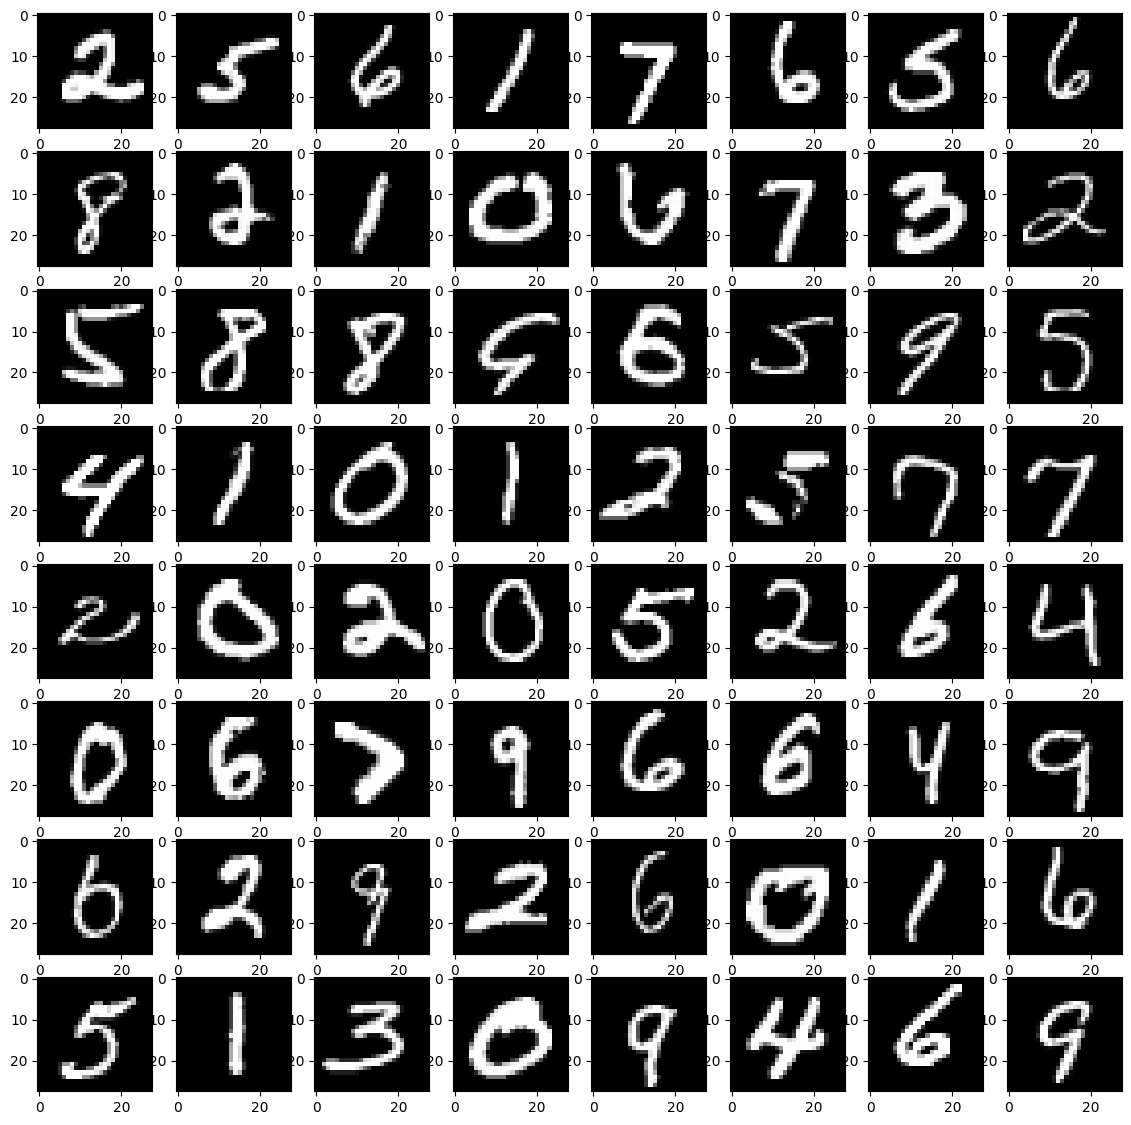

In [ ]:
# Plot sample images

fig, axs = plt.subplots(8,8, figsize=(14, 14))

axs = axs.flatten()

for x, _ in train_loader:

  break

for a, img in zip(axs, x):

  a.imshow(img.permute(1, 2, 0), cmap='gray')

In [ ]:
# try straight linear no featurization

class Model(nn.Module):

  def __init__(self) -> None:

    super().__init__()

    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 64)
    self.out = nn.Linear(64, 10)

  def forward(self, x) -> None:

    x = nn.Flatten()(x)
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.fc2(x)
    x = nn.ReLU()(x)
    x = self.out(x)

    return x # <-- Return Logits for Categorical Cross Entropy

model = Model()
model.to(device)

next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
from IPython.display import clear_output

epochs: int = 10
lr: float = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss()

loss_hist = torch.zeros(size=(train_loader.__len__() * epochs,))

def hist():
  yield from [l for l in range(loss_hist.shape[0])]

h = hist()

for i in range(epochs):

  print(f"{i + 1}/{epochs}")

  print(
      'Loss:',
      loss_hist[i * train_loader.__len__() - 1].item()
    )

  for x, y in train_loader:

    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    loss = loss_fn(
        model(x),
        y
    )

    loss.backward()

    loss_item = loss.detach().item()

    loss_hist[next(h)] = loss_item

    optimizer.step()

  clear_output(wait=True)


10/10
0.39243951439857483


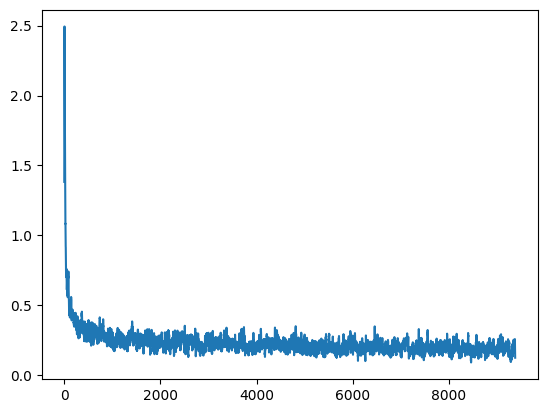

In [ ]:
# Show smoothed graph

s: int = 10

conv_window = torch.ones((1,1, s)) / s

smoothed_graph = F.conv1d(loss_hist.view(1, 1, -1), conv_window, padding=s//2)

plt.plot(range(smoothed_graph.shape[-1]), smoothed_graph.view(-1))

In [ ]:
from torchmetrics.classification import Accuracy

metric = Accuracy(task="multiclass", num_classes=10)
metric.to(device)

acc = []

# During training or eval
for x, y in test_loader:

  x = x.to(device)
  y = y.to(device)

  acc.append(metric(model(x), y))

sum(acc) / acc.__len__()

tensor(0.9438, device='cuda:0')

### RNN Model (IMDB)

In [9]:
dataset = load_dataset("imdb")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [10]:
train_dist = torch.tensor(dataset['train']['label']).unique(return_counts=True)
test_dist = torch.tensor(dataset['test']['label']).unique(return_counts=True)

for dist in (train_dist, test_dist):

  for label, num in zip(*dist):

    print(
        f"Label {label} has {num} examples"
    )

# 50/50 for both sets

Label 0 has 12500 examples
Label 1 has 12500 examples
Label 0 has 12500 examples
Label 1 has 12500 examples


In [20]:
# Dataset and Loader

class TextDataset(Dataset):

  def __init__(self, text, labels) -> None:

    self.text = text
    self.labels = labels

  def __len__(self) -> int:

    return self.text.__len__()

  def __getitem__(self, idx: int) -> Tuple[str, int]:

    return self.text[idx], self.labels[idx]

train = TextDataset(dataset['train']['text'], dataset['train']['label'])
test = TextDataset(dataset['test']['text'], dataset['test']['label'])

train_loader = DataLoader(train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

In [23]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
bert.eval()

class Model(nn.Module):
    def __init__(self, embedder, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.embedder = embedder

        self.rnn = nn.RNN(
            input_size=768,
            hidden_size=384,
            num_layers=3,
            batch_first=True
        )

        self.fc1 = nn.Linear(384, 192)
        self.fc2 = nn.Linear(192, 96)
        self.fc3 = nn.Linear(96, 32)
        self.output = nn.Linear(32, 2)
        self.act = nn.GELU()

    def forward(self, text: str) -> torch.Tensor:

        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            bert_output = self.embedder(**encoding)

            x = bert_output.last_hidden_state

        x, _ = self.rnn(x)

        x = x[:, -1, :]

        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.output(x)

        return x

model = Model(bert, tokenizer)

model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model(
  (embedder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
from tqdm import tqdm

epochs = 10
lr = 1e-2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_hist = []

model.train()

for e in range(epochs):

  total_loss = 0

  loop = tqdm(train_loader, desc=f"Epoch {e + 1}")

  batch_num = 0

  for x, y in loop:

    y = y.to(device)

    optimizer.zero_grad()

    logits = model(x)

    loss = loss_fn(logits, y)

    loss.backward()

    optimizer.step()

    total_loss += loss.item()

    loss_hist.append(loss.item())

    loop.set_postfix(loss=loss.item())

    batch_num += 1

  print(f"Epoch {e+1} average loss: {total_loss/len(train_loader):.4f}")

# Ran out of free GPU run time :(

Epoch 1: 100%|██████████| 196/196 [15:32<00:00,  4.76s/it, loss=0.695]


Epoch 1 average loss: 0.6935


Epoch 2: 100%|██████████| 196/196 [15:33<00:00,  4.76s/it, loss=0.694]


Epoch 2 average loss: 0.6933


Epoch 3:  88%|████████▊ | 172/196 [13:43<01:54,  4.76s/it, loss=0.693]

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
a = torch.tensor([], device=device)

loop = tqdm(test_loader, desc=f"Batch")

batch_num = 0

for x, y in loop:

  if batch_num >= 32:

    break

  logits = model(x).softmax(dim=0)

  a = torch.concat([a, logits.argmax() == y.to(device)])

  batch_num += 1

In [ ]:
a.mean()

In [ ]:
model("Hello I love this movie")